In [1]:
import os
import sys
import nltk
import re
import transformers
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn as nn

from pandas import read_excel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import accuracy, auroc
from torchmetrics import F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

%matplotlib inline

IMPORTING DATASET

In [2]:
column_names = ['ID', 'TITLE', 'ABSTRACT', 'COMPUTER SCIENCE', 'PHYSICS', 'MATHEMATICS', 'STATISTICS', 'QUANTITATIVE BIOLOGY', 'QUANTITATIVE FINANCE']
exel = read_excel('./train.xlsx', header=None, names=column_names)

data = pd.DataFrame(exel)

data.head(10)

,ID,TITLE,ABSTRACT,COMPUTER SCIENCE,PHYSICS,MATHEMATICS,STATISTICS,QUANTITATIVE BIOLOGY,QUANTITATIVE FINANCE
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
5,6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0
6,7,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,0,1,0,0,0,0
7,8,Adverse effects of polymer coating on heat tra...,The ability of metallic nanoparticles to sup...,0,1,0,0,0,0
8,9,SPH calculations of Mars-scale collisions: the...,We model large-scale ($\approx$2000km) impac...,0,1,0,0,0,0
9,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0


EDA

In [3]:
print(data.shape)
print(data.info())

(20972, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   COMPUTER SCIENCE      20972 non-null  int64 
 4   PHYSICS               20972 non-null  int64 
 5   MATHEMATICS           20972 non-null  int64 
 6   STATISTICS            20972 non-null  int64 
 7   QUANTITATIVE BIOLOGY  20972 non-null  int64 
 8   QUANTITATIVE FINANCE  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB
None


In [4]:
data.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
COMPUTER SCIENCE        0
PHYSICS                 0
MATHEMATICS             0
STATISTICS              0
QUANTITATIVE BIOLOGY    0
QUANTITATIVE FINANCE    0
dtype: int64

In [5]:
data.duplicated().sum()

0

In [6]:
data.nunique()

ID                      20972
TITLE                   20972
ABSTRACT                20972
COMPUTER SCIENCE            2
PHYSICS                     2
MATHEMATICS                 2
STATISTICS                  2
QUANTITATIVE BIOLOGY        2
QUANTITATIVE FINANCE        2
dtype: int64

In [7]:
categories = list(data.columns.values)
categories = categories[3:]
print(categories)

['COMPUTER SCIENCE', 'PHYSICS', 'MATHEMATICS', 'STATISTICS', 'QUANTITATIVE BIOLOGY', 'QUANTITATIVE FINANCE']


c:\Users\malik\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


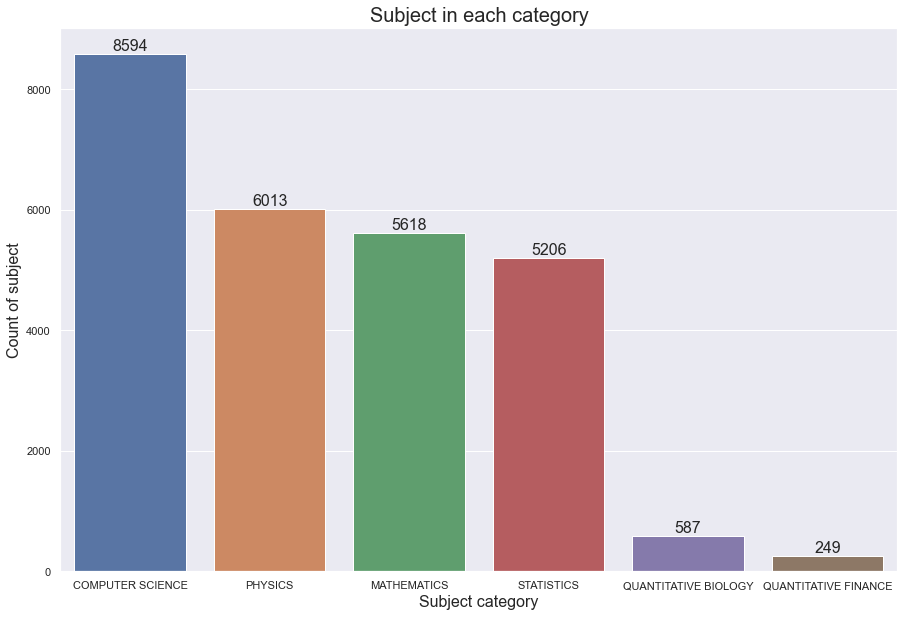

In [8]:
sns.set(font_scale=1)
plt.figure(figsize=(15, 10))

ax = sns.barplot(categories, data.iloc[:,3:].sum().values)

plt.title('Subject in each category', fontsize=20)
plt.ylabel('Count of subject', fontsize=16)
plt.xlabel('Subject category', fontsize=16)

rects = ax.patches
labels = data.iloc[:, 3:].sum().values

for rect, labels in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, labels, ha='center', va='bottom', fontsize=16)

plt.show()

Imbalanced data noticed maybe do some augmentation for quantitative biology and quantitative finance

c:\Users\malik\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


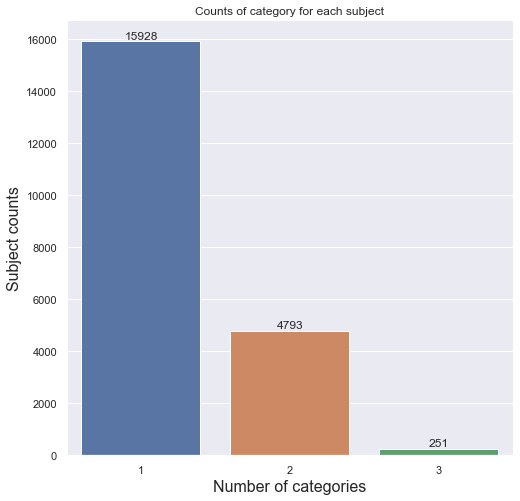

In [9]:
row_sums = data.iloc[:, 3:].sum(axis=1)
multilabel_count = row_sums.value_counts()

sns.set(font_scale=1)
plt.figure(figsize=(8, 8))

ax = sns.barplot(multilabel_count.index, multilabel_count.values)

plt.title('Counts of category for each subject')
plt.xlabel('Number of categories', fontsize=16)
plt.ylabel('Subject counts', fontsize=16)

rects = ax.patches
labels = multilabel_count.values

for rect, labels in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, labels, ha='center', va='bottom')

plt.show()

PREPROCESSING

CLEANING DATA

In [10]:
# cleaning data

stop_words = set(stopwords.words('english'))
re_stopwords = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def clean_html(sentences):
  cleaner = re.compile('<.*?>')
  cleantext = re.sub(cleaner, ' ', str(sentences))

  return cleantext

def clean_punctation(sentences):
  cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentences)
  cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
  cleaned = cleaned.strip()
  cleaned = cleaned.replace('\n', ' ')

  return cleaned

def keep_alpha(sentences):
  alpha_sent = ''

  for word in sentences.split():
    alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
    alpha_sent += alpha_word
    alpha_sent += ' '
  alpha_sent = alpha_sent.strip()

  return alpha_sent

def remove_stopwords(sentences):
  global re_stopwords
  
  return re_stopwords.sub(' ', sentences)

In [11]:
data['ABSTRACT'] = data['ABSTRACT'].str.lower()
data['ABSTRACT'] = data['ABSTRACT'].apply(clean_html)
data['ABSTRACT'] = data['ABSTRACT'].apply(clean_punctation)
data['ABSTRACT'] = data['ABSTRACT'].apply(keep_alpha)
data['ABSTRACT'] = data['ABSTRACT'].apply(remove_stopwords)

In [12]:
data.head(10)

,ID,TITLE,ABSTRACT,COMPUTER SCIENCE,PHYSICS,MATHEMATICS,STATISTICS,QUANTITATIVE BIOLOGY,QUANTITATIVE FINANCE
0,1,Reconstructing Subject-Specific Effect Maps,predictive models allow subject specific infer...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,rotation invariance translation invariance g...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyhar...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,stochastic landau lifshitz gilbert llg equati...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,fourier transform infra red ftir spectra samp...,1,0,0,1,0,0
5,6,On maximizing the fundamental frequency of the...,let omega subset mathbb r n bounded doma...,0,0,1,0,0,0
6,7,On the rotation period and shape of the hyperb...,observed newly discovered hyperbolic minor p...,0,1,0,0,0,0
7,8,Adverse effects of polymer coating on heat tra...,ability metallic nanoparticles supply heat ...,0,1,0,0,0,0
8,9,SPH calculations of Mars-scale collisions: the...,model large scale approx km impacts mars l...,0,1,0,0,0,0
9,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,time varying susceptibility host individual ...,0,0,0,0,1,0


APPLYING LEMMATIZER using WordNetLemmatizer

In [13]:
# lemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
  lemmatized = ''

  for word in sentence.split():
    lmtz = lemmatizer.lemmatize(word)
    lemmatized += lmtz
    lemmatized += ' '

  lemmatized = lemmatized.strip()

  return lemmatized

In [14]:
data['ABSTRACT'] = data['ABSTRACT'].apply(lemmatize_sentence)

In [15]:
data.head()

,ID,TITLE,ABSTRACT,COMPUTER SCIENCE,PHYSICS,MATHEMATICS,STATISTICS,QUANTITATIVE BIOLOGY,QUANTITATIVE FINANCE
0,1,Reconstructing Subject-Specific Effect Maps,predictive model allow subject specific infere...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,rotation invariance translation invariance gre...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyharmoni...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,stochastic landau lifshitz gilbert llg equatio...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,fourier transform infra red ftir spectrum samp...,1,0,0,1,0,0


In [16]:
BERT_MODEL_NAME = 'bert-base-cased'
MAX_TOKEN_COUNT = 400

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

class subject_classification_dataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    x = data_row.ABSTRACT
    y = data_row[categories]

    encoding = self.tokenizer.encode_plus(
      x,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      x=x,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      y=torch.FloatTensor(y)
    )

In [17]:
sample_row = data.iloc[16]
sample_subject = sample_row.ABSTRACT
sample_labels = sample_row[categories]

print(sample_subject)
print()
print(sample_labels.to_dict())

process lead formation bright star forming site observed along prominent spiral arm remains elusive present result multi wavelength study spiral arm segment nearby grand design spiral galaxy belongs spiral density wave exhibit nine gas spur combined observation ionized atomic molecular dusty interstellar medium ism star formation tracer hii region young myr stellar cluster suggest variation giant molecular cloud gmc property arm gas spur gas spur extinction feather arising structure close spatial relation gas spur ongoing recent star formation despite higher gas surface density spiral arm trend star formation age either along arm along spur evidence strong star formation feedback gas spur tentative evidence star formation triggered stellar feedback one spur gmc association gmas special entity result blending gas arm spur cross section lower resolution observation conclude evidence coherent star formation onset mechanism solely associated presence spiral density wave suggests localized 

In [18]:
encoding = tokenizer.encode_plus(
  sample_subject,
  add_special_tokens=True,
  max_length=400,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 400]), torch.Size([1, 400]))

In [20]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,  1965,  1730,  3855,  3999,  2851,  5071,  1751,  4379,  1373,
         3289, 14061,  1981,  2606,  8468, 17849,  1675,  1871,  4321, 22335])

In [21]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'process', 'lead', 'formation', 'bright', 'star', 'forming', 'site', 'observed', 'along', 'prominent', 'spiral', 'arm', 'remains', 'el', '##usive', 'present', 'result', 'multi', 'wavelength']


In [22]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
token_counts = []

for _, row in data.iterrows():
  token_count = len(tokenizer.encode(
    row['ABSTRACT'], 
    max_length=400, 
    truncation=True
  ))
  token_counts.append(token_count)

(0.0, 512.0)

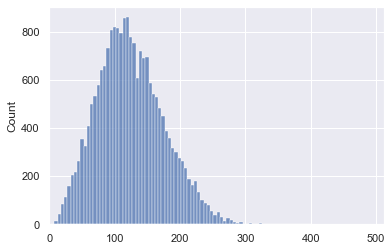

In [24]:
sns.histplot(token_counts)
plt.xlim([0, 512])

In [25]:
x = subject_classification_dataset(
  data,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = x[0]
sample_item.keys()

dict_keys(['x', 'input_ids', 'attention_mask', 'y'])

In [26]:
sample_item['x']

'predictive model allow subject specific inference analyzing disease related alteration neuroimaging data given subject data inference made two level global e identifiying condition presence subject local e detecting condition effect individual measurement extracted subject data global inference widely used local inference used form subject specific effect map rarely used existing model often yield noisy detection composed dispersed isolated island article propose reconstruction method named rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise due sampling error associated using finite sample example train classifier proposed method wrapper type algorithm used different binary classifier diagnostic manner e without information condition presence reconstruction posed maximum posteriori problem prior model whose parameter estimated training data classifier specific fashion experimental evaluation performed synt

In [27]:
sample_item['y']

tensor([1., 0., 0., 0., 0., 0.])

In [28]:
sample_item['input_ids']

tensor([  101, 17163,  2109,  2235,  2621,  2548,  2747,  1107, 16792, 23389,
         3653,  2272, 13000,  1891, 24928, 11955,  8628,  3375,  2233,  1549,
         2548,  2233,  1107, 16792,  1189,  1160,  1634,  4265,   174, 25021,
         3452,  8914,  1182,  9257,  3879,  2915,  2548,  1469,   174, 11552,
         1158,  3879,  2629,  2510, 11842, 16939,  2548,  2233,  4265,  1107,
        16792,  3409,  1215,  1469,  1107, 16792,  1215,  1532,  2548,  2747,
         2629,  4520,  6034,  1215,  3685,  2235,  1510, 10972, 24678, 11432,
         2766, 16478,  6841,  2248,  3342, 17794, 10442,  3442,  1417,   187,
         6602,  4607,  2548,  2747, 11432, 17163,  2109, 13117,  3136,  2440,
        13480,  1705, 17792,   187,  6602,  4418,  6457,  4851,  4647,  1496,
        18200,  7353,  2628,  1606, 10996,  6876,  1859,  2669,  1705, 17792,
         3000,  3442, 10561,  3365,  2076,  9932,  1215,  1472, 13480,  1705,
        17792, 20346,  4758,   174,  1443,  1869,  3879,  2915, 

In [29]:
sample_item['input_ids'].shape

torch.Size([400])

In [30]:
train_data, val_data = train_test_split(data, test_size=0.20)

In [31]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# DATALOADER BROKEN NEED TO FIX

# sample_batch = next(iter(DataLoader(train_data, batch_size=4, num_workers=4)))
# sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

In [ ]:
class SubjectDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = subject_classification_dataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = subject_classification_dataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=6,
      pin_memory=True
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=6,
      pin_memory=True
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=6,
      pin_memory=True
    )

In [ ]:
NUM_EPOCH = 10
BATCH_SIZE = 4

data_module = SubjectDataModule(
  train_data,
  val_data,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class SubjectClasifier(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(categories):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

c:\Users\malik\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


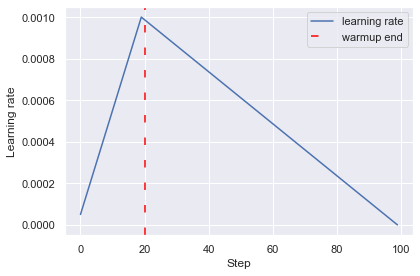

In [ ]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [ ]:
steps_per_epoch=len(train_data) // BATCH_SIZE
total_training_steps = steps_per_epoch * NUM_EPOCH

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(8388, 41940)

In [ ]:
model = SubjectClasifier(
  n_classes=len(categories),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("./tensorboard")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=NUM_EPOCH,
  num_sanity_val_steps=0,
  accelerator='gpu',
  devices=1,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]